In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from keras.models import Sequential
from keras.layers import InputLayer, Bidirectional, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.constraints import MaxNorm
from keras.callbacks import ModelCheckpoint

import time

In [2]:
filepath = 'C:/Users/ss230/Documents/Study/NSIDC/Edited Data/N_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0.xlsx'
Bering = pd.read_excel(filepath, sheet_name='Bering-Extent-km^2')

In [3]:
import sys
sys.path.append('C:/Users/ss230/Documents/Study/NSIDC/NH/')
import Function as fp

In [4]:
fp.month_mapping(Bering)
fp.date_time(Bering)

,Extent,Date
0,320266.650,1979-01-01
1,541778.338,1979-02-01
2,638262.988,1979-03-01
3,423025.159,1979-04-01
4,215587.216,1979-05-01
...,...,...
488,317377.493,2023-05-01
489,39601.476,2023-06-01
490,16935.702,2023-07-01
491,1305.744,2023-09-01


In [5]:
scaler = MinMaxScaler()
Bering['Extent'] = scaler.fit_transform(Bering['Extent'].values.reshape(-1, 1))

In [6]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    lead_time = 10
    for i in range(len(df_as_np) - window_size - lead_time + 1):
        window_data = df_as_np[i:i+window_size]
        row = [[a] for a in window_data]
        X.append(row)
        label = df_as_np[i+window_size+lead_time-1]
        y.append(label)
    return np.array(X), np.array(y)

In [7]:
extent = Bering['Extent']
W_S=12
X,y = df_to_X_y(extent, W_S)
X.shape, y.shape

((472, 12, 1), (472,))

In [8]:
X_train, y_train = X[:390], y[:390]
X_val, y_val = X[390:440], y[390:440]
X_test, y_test = X[440:], y[440:]

In [9]:
model = Sequential()
model.add(InputLayer((W_S, 1)))
model.add(Bidirectional(LSTM(128, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(64, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(32, activation='relu', kernel_constraint=MaxNorm(1.0))))
model.add(Dense(1, activation='linear'))

cp = ModelCheckpoint('Bering_model_LT10/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(0.0001), metrics=[RootMeanSquaredError()])

In [10]:
stime = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=8, callbacks=[cp])
etime = time.time()

Epoch 1/50
49/49 [==============================] - 29s 402ms/step - loss: 0.1582 - root_mean_squared_error: 0.3977 - val_loss: 0.0400 - val_root_mean_squared_error: 0.1999
Epoch 2/50
49/49 [==============================] - 1s 27ms/step - loss: 0.0987 - root_mean_squared_error: 0.3141 - val_loss: 0.0405 - val_root_mean_squared_error: 0.2011
Epoch 3/50
49/49 [==============================] - 19s 400ms/step - loss: 0.0754 - root_mean_squared_error: 0.2747 - val_loss: 0.0377 - val_root_mean_squared_error: 0.1941
Epoch 4/50
49/49 [==============================] - 18s 377ms/step - loss: 0.0578 - root_mean_squared_error: 0.2404 - val_loss: 0.0284 - val_root_mean_squared_error: 0.1686
Epoch 5/50
49/49 [==============================] - 18s 380ms/step - loss: 0.0395 - root_mean_squared_error: 0.1987 - val_loss: 0.0191 - val_root_mean_squared_error: 0.1381
Epoch 6/50
49/49 [==============================] - 18s 369ms/step - loss: 0.0333 - root_mean_squared_error: 0.1824 - val_loss: 0.0170 - 

49/49 [==============================] - 3s 51ms/step - loss: 0.0107 - root_mean_squared_error: 0.1033 - val_loss: 0.0243 - val_root_mean_squared_error: 0.1558
Epoch 43/50
49/49 [==============================] - 2s 51ms/step - loss: 0.0101 - root_mean_squared_error: 0.1004 - val_loss: 0.0389 - val_root_mean_squared_error: 0.1973
Epoch 44/50
49/49 [==============================] - 2s 39ms/step - loss: 0.0114 - root_mean_squared_error: 0.1068 - val_loss: 0.0283 - val_root_mean_squared_error: 0.1681
Epoch 45/50
49/49 [==============================] - 2s 33ms/step - loss: 0.0096 - root_mean_squared_error: 0.0979 - val_loss: 0.0242 - val_root_mean_squared_error: 0.1556
Epoch 46/50
49/49 [==============================] - 3s 58ms/step - loss: 0.0094 - root_mean_squared_error: 0.0967 - val_loss: 0.0249 - val_root_mean_squared_error: 0.1576
Epoch 47/50
49/49 [==============================] - 2s 51ms/step - loss: 0.0097 - root_mean_squared_error: 0.0983 - val_loss: 0.0225 - val_root_mean_sq

In [11]:
time = (etime - stime)/60
print(f'{time} minutes')

4.3293708244959515 minutes


In [12]:
loss = history.history['loss']
epochs = list(range(1, len(loss) + 1))

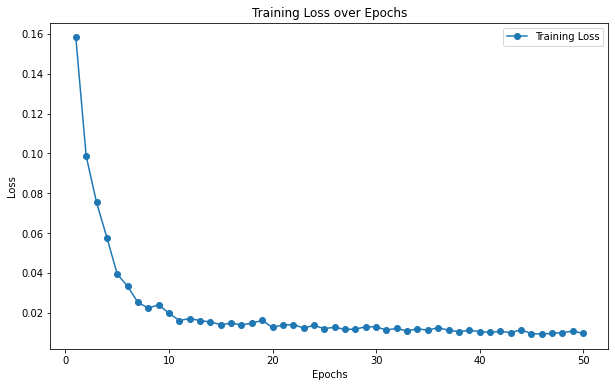

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss', marker='o', linestyle='-')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

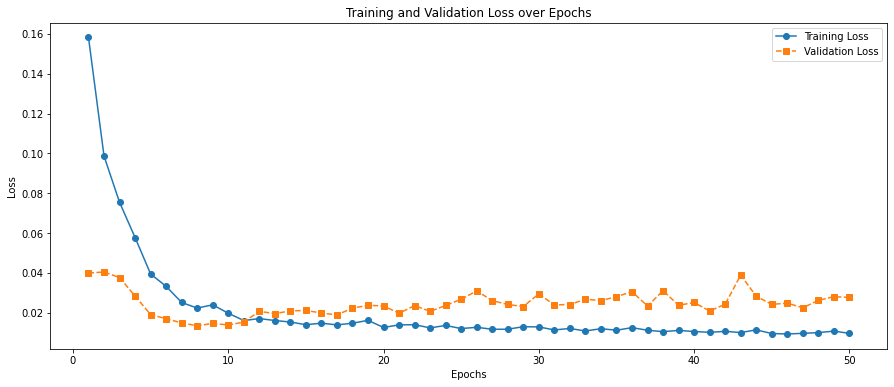

In [14]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(15,6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [15]:
from tensorflow.keras.models import load_model
model1 = load_model('Bering_model_LT10/')

In [16]:
test_predictions = model1.predict(X_test)

1/1 [==============================] - 1s 1s/step


In [17]:
mse = mean_squared_error(y_test, test_predictions)
print('RMSE :', np.sqrt(mse))

mae = mean_absolute_error(y_test, test_predictions)
print('MAE :', mae)

RMSE : 0.10808331276873806
MAE : 0.08208862778707546


In [18]:
test_predictions = scaler.inverse_transform(test_predictions)
test_original = scaler.inverse_transform(y_test.reshape(-1,1))

In [19]:
train_results = pd.DataFrame(data={'Train Predictions': test_predictions.flatten(), 'Actual Extent': test_original.flatten()})
train_results

,Train Predictions,Actual Extent
0,234216.421875,168828.990
1,417815.000000,461098.498
2,515082.156250,591635.798
3,483970.437500,598360.298
4,380851.968750,531742.038
5,246691.718750,302131.004
6,138818.078125,57748.135
7,63364.437500,3054.962
8,16516.792969,442.539
9,-6609.526367,8541.643


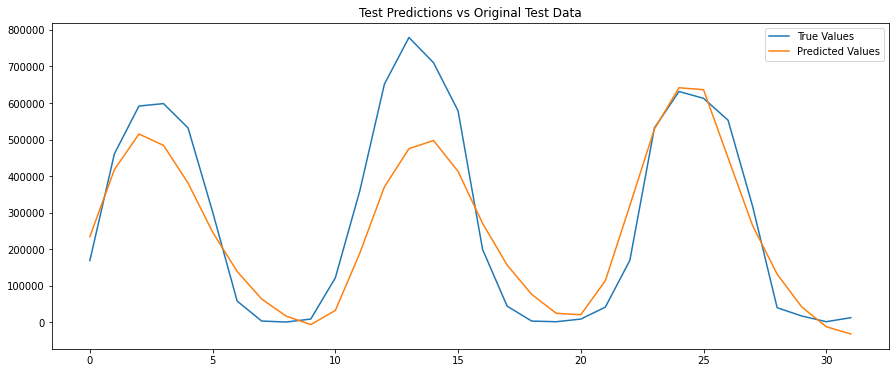

In [20]:
plt.figure(figsize=(15,6))
plt.plot(test_original, label='True Values')
plt.plot(test_predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()

In [21]:
predictions = model1.predict(X)

15/15 [==============================] - 1s 20ms/step


In [22]:
predictions = scaler.inverse_transform(predictions)
Original = scaler.inverse_transform(y.reshape(-1,1))

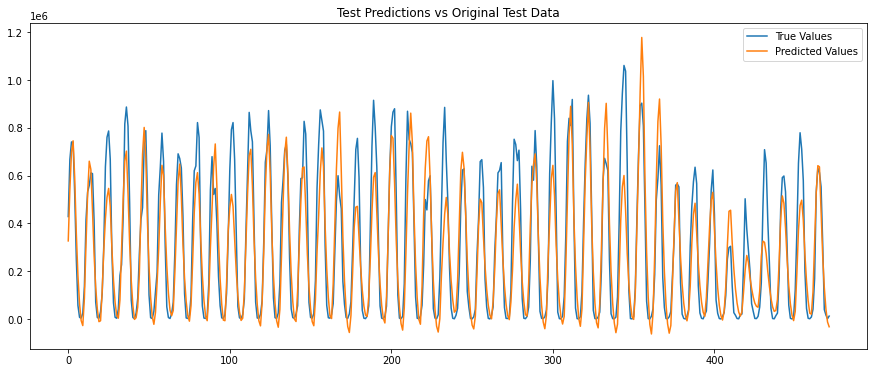

In [23]:
plt.figure(figsize=(15,6))
plt.plot(Original, label='True Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()